In [1]:
import warnings
import numpy as np
import gc
import json
import h5py
import threading
import time
import seaborn as sn
import pandas as pd

import tensorflow as tf
from keras.utils import Sequence
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.sequence import _remove_long_seq
from keras.models import Sequential
from keras.layers import Embedding, Input, Dense, Dropout, CuDNNLSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.95, allow_growth=False)
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, allow_soft_placement=True, gpu_options=gpu_options)
session = tf.Session(config=config)
K.set_session(session)


Using TensorFlow backend.


In [2]:
def load_vocab():
    with open('data/word_index_2019.json') as json_data:
        return json.load(json_data)

def load_index_vocab():
    index_vocab = {}
    with open('data/word_index_2019.json') as json_data:
        for word, index in json.load(json_data).items():
            index_vocab[index] = word
    return index_vocab

    
def load_glove():
    glove = {}
    with open('data/glove.arxmliv.15B.300d.txt') as glove_data:
        for line in glove_data:
            items = line.split()
            key = items[0]
            glove[key] = np.asarray(items[1:], dtype='float32')
    return glove


def build_embedding_layer(with_input=False, maxlen=512, vocab_dim=300, mask_zero=True):
    print("-- loading word embeddings, this may take a couple of minutes...")
    index_dict = load_vocab()
    word_vectors = load_glove()
    # adding 1 to account for 0th index (for masking)
    n_symbols = len(index_dict) + 1
    print("-- known dictionary items: ", n_symbols)
    embedding_weights = np.zeros((n_symbols, vocab_dim))
    for word, index in index_dict.items():
        embedding_weights[index, :] = word_vectors[word]
    print("-- embeddings ")
    if not with_input:
        embedding_layer = Embedding(
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False, weights=[embedding_weights])
        return embedding_layer
    else:
        # define inputs here
        input_1 = Input(shape=(maxlen,), dtype='int32')
        embedding_layer = Embedding(
            weights=[embedding_weights],
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False)(input_1)
        return (embedding_layer, input_1)


In [3]:
# Input data is obtained via batch loading from HDF5
class DataGenerator(Sequence):
    def __init__(self, batch_size=128, mode="train", dim=512,
             n_classes=20, x_hf = None, y_hf = None, shuffle=False):
        'Initialization'
        self.x_hf = x_hf
        self.y_hf = y_hf
        self.mode = mode
        self.total_len = self.y_hf.shape[0]
        self.validation_len = int(np.ceil(0.1 * self.total_len))
        self.training_len = self.total_len - self.validation_len
        if self.mode == "validation":
            self.data_len = self.validation_len
            self.list_IDs = np.arange(self.training_len, self.total_len)
        else:
            self.data_len = self.training_len
            self.list_IDs = np.arange(0,self.training_len+1)
            
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end() 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples,  dim)
        # Initialization
        X = np.empty((self.batch_size, self.dim), dtype=int)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.x_hf[ID]
            # Store class
            y[i] = self.y_hf[ID]
        
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

# Parameters
batch_size = 128
data_hf = h5py.File("data/confusion_free_statements_2019.hdf5", 'r')
generator_params = {
    'batch_size': batch_size,
    'n_classes': 20,
    'shuffle': False,
    'x_hf': data_hf['x_train'],
    'y_hf': data_hf['y_train']
}

# Generators
training_generator = DataGenerator(**generator_params)
validation_generator = DataGenerator(mode="validation", **generator_params)

In [4]:
# Preparing word embeddings
# (takes 10 minutes to recompute, memoizing here)
#
# class_weights = compute_class_weight('balanced', np.unique(training_generator.y_hf), training_generator.y_hf)
# np.set_printoptions(precision=32, suppress=True)
# print(class_weights)

class_weights = [ 0.9267723205685297,   1.589448561196638,    0.15248861029082741,
  1.2648763710781212,  37.06216615305598,     1.2814478583352078,
  2.773750256259129,    7.661453420985109,    0.9770567467114394,
  3.086147236290153,   15.558997556330183,   13.328209607659037,
  8.523845828247431,    0.3902291567617018,   0.23140083857106208,
 27.211377349003833,   19.712266663631397,    1.3564001810788289,
  3.6081071114574175,  18.22338215796452   ]


In [5]:
maxlen = 512
embedding_layer = build_embedding_layer(maxlen=maxlen, mask_zero=False)

-- loading word embeddings, this may take a couple of minutes...
-- known dictionary items:  989137
-- embeddings 


In [6]:
# BiLSTM Model Setup
n_classes = 20
layer_size = 128  # ~ maxlen // 4

print("-- setting up model layout...")
use_dropout = True

model = Sequential()
model.add(embedding_layer)
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size // 2, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.1))

model.add(CuDNNLSTM(layer_size // 2))
if use_dropout:
    model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])

# Print model summary
print(model.summary())

-- setting up model layout...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 512, 300)          296741100 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512, 256)          440320    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512, 128)          164864    
___________________________________

In [7]:
model_file = "confusion_bilstm%d_batch%d_cat%d_gpu" % (
    layer_size, batch_size, n_classes)

# Checkpoints: 1) save best model at epoch end,
checkpoint = ModelCheckpoint(model_file+"-checkpoint.h5",
                             monitor='val_weighted_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# 2) stop early when metric stops improving
earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
                          min_delta=0.001,
                          patience=3,
                          restore_best_weights=True,
                          verbose=0, mode='auto')

In [8]:
# Perform training
print('-- training model...')
# TODO: How can we make this work with more workers? HDF5 is not thread-safe for reads...
# maybe use the unpacked .txt files and map them through the dictionary each time? Unsure... 
# On a single CPU worker: 5 hours per epoch for the full data, with the main BiLSTM model.
model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    workers = 1,
    use_multiprocessing=False,
    class_weight=class_weights,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, earlystop])

print("-- saving model to disk : %s " % model_file)
model.save(model_file+'_notebook.h5')

-- training model...
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
121770/121770 [==============================] - 19184s 158ms/step - loss: 0.3845 - weighted_sparse_categorical_accuracy: 0.8873 - val_loss: 0.3377 - val_weighted_sparse_categorical_accuracy: 0.8995

Epoch 00001: val_weighted_sparse_categorical_accuracy improved from -inf to 0.89949, saving model to confusion_bilstm128_batch128_cat20_gpu-checkpoint.h5
Epoch 2/50
121770/121770 [==============================] - 19270s 158ms/step - loss: 0.3102 - weighted_sparse_categorical_accuracy: 0.9083 - val_loss: 0.3250 - val_weighted_sparse_categorical_accuracy: 0.9032

Epoch 00002: val_weighted_sparse_categorical_accuracy improved from 0.89949 to 0.90325, saving model to confusion_bilstm128_batch128_cat20_gpu-checkpoint.h5
Epoch 3/50
121770/121770 [==============================] - 19587s 161ms/step - loss: 0.3023 - weighted_sparse_categorical_accuracy: 0.9105 - val_loss: 0.3207 - val_weighted_sparse_categorical_accur

In [9]:
## If we want to load the pre-trained model we can:
#
# from keras.models import load_model
# model = load_model(model_file+"_notebook.h5")

In [10]:
print("Per-class test measures:")
y_pred = model.predict_classes(data_hf['x_test'], verbose=1, batch_size=batch_size)
print(classification_report(data_hf['y_test'], y_pred))

Per-class test measures:
4329582/4329582 [==============================] - 1976s 456us/step
              precision    recall  f1-score   support

           0       0.90      0.94      0.92    233585
           1       1.00      1.00      1.00    136198
           2       0.99      0.99      0.99   1419647
           3       0.84      0.78      0.81    171145
           4       0.66      0.47      0.55      5841
           5       0.85      0.86      0.85    168934
           6       0.72      0.59      0.65     78045
           7       0.72      0.66      0.69     28253
           8       0.82      0.90      0.86    221562
           9       0.68      0.66      0.67     70144
          10       0.61      0.43      0.51     13913
          11       0.83      0.48      0.61     16241
          12       0.61      0.37      0.46     25397
          13       0.91      0.93      0.92    554749
          14       0.94      0.96      0.95    935516
          15       0.67      0.71      0.6

In [11]:
np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        annot = True
        print("Normalized confusion matrix")
    else:
        annot = False
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(50,40))
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=annot)

Confusion matrix, without normalization


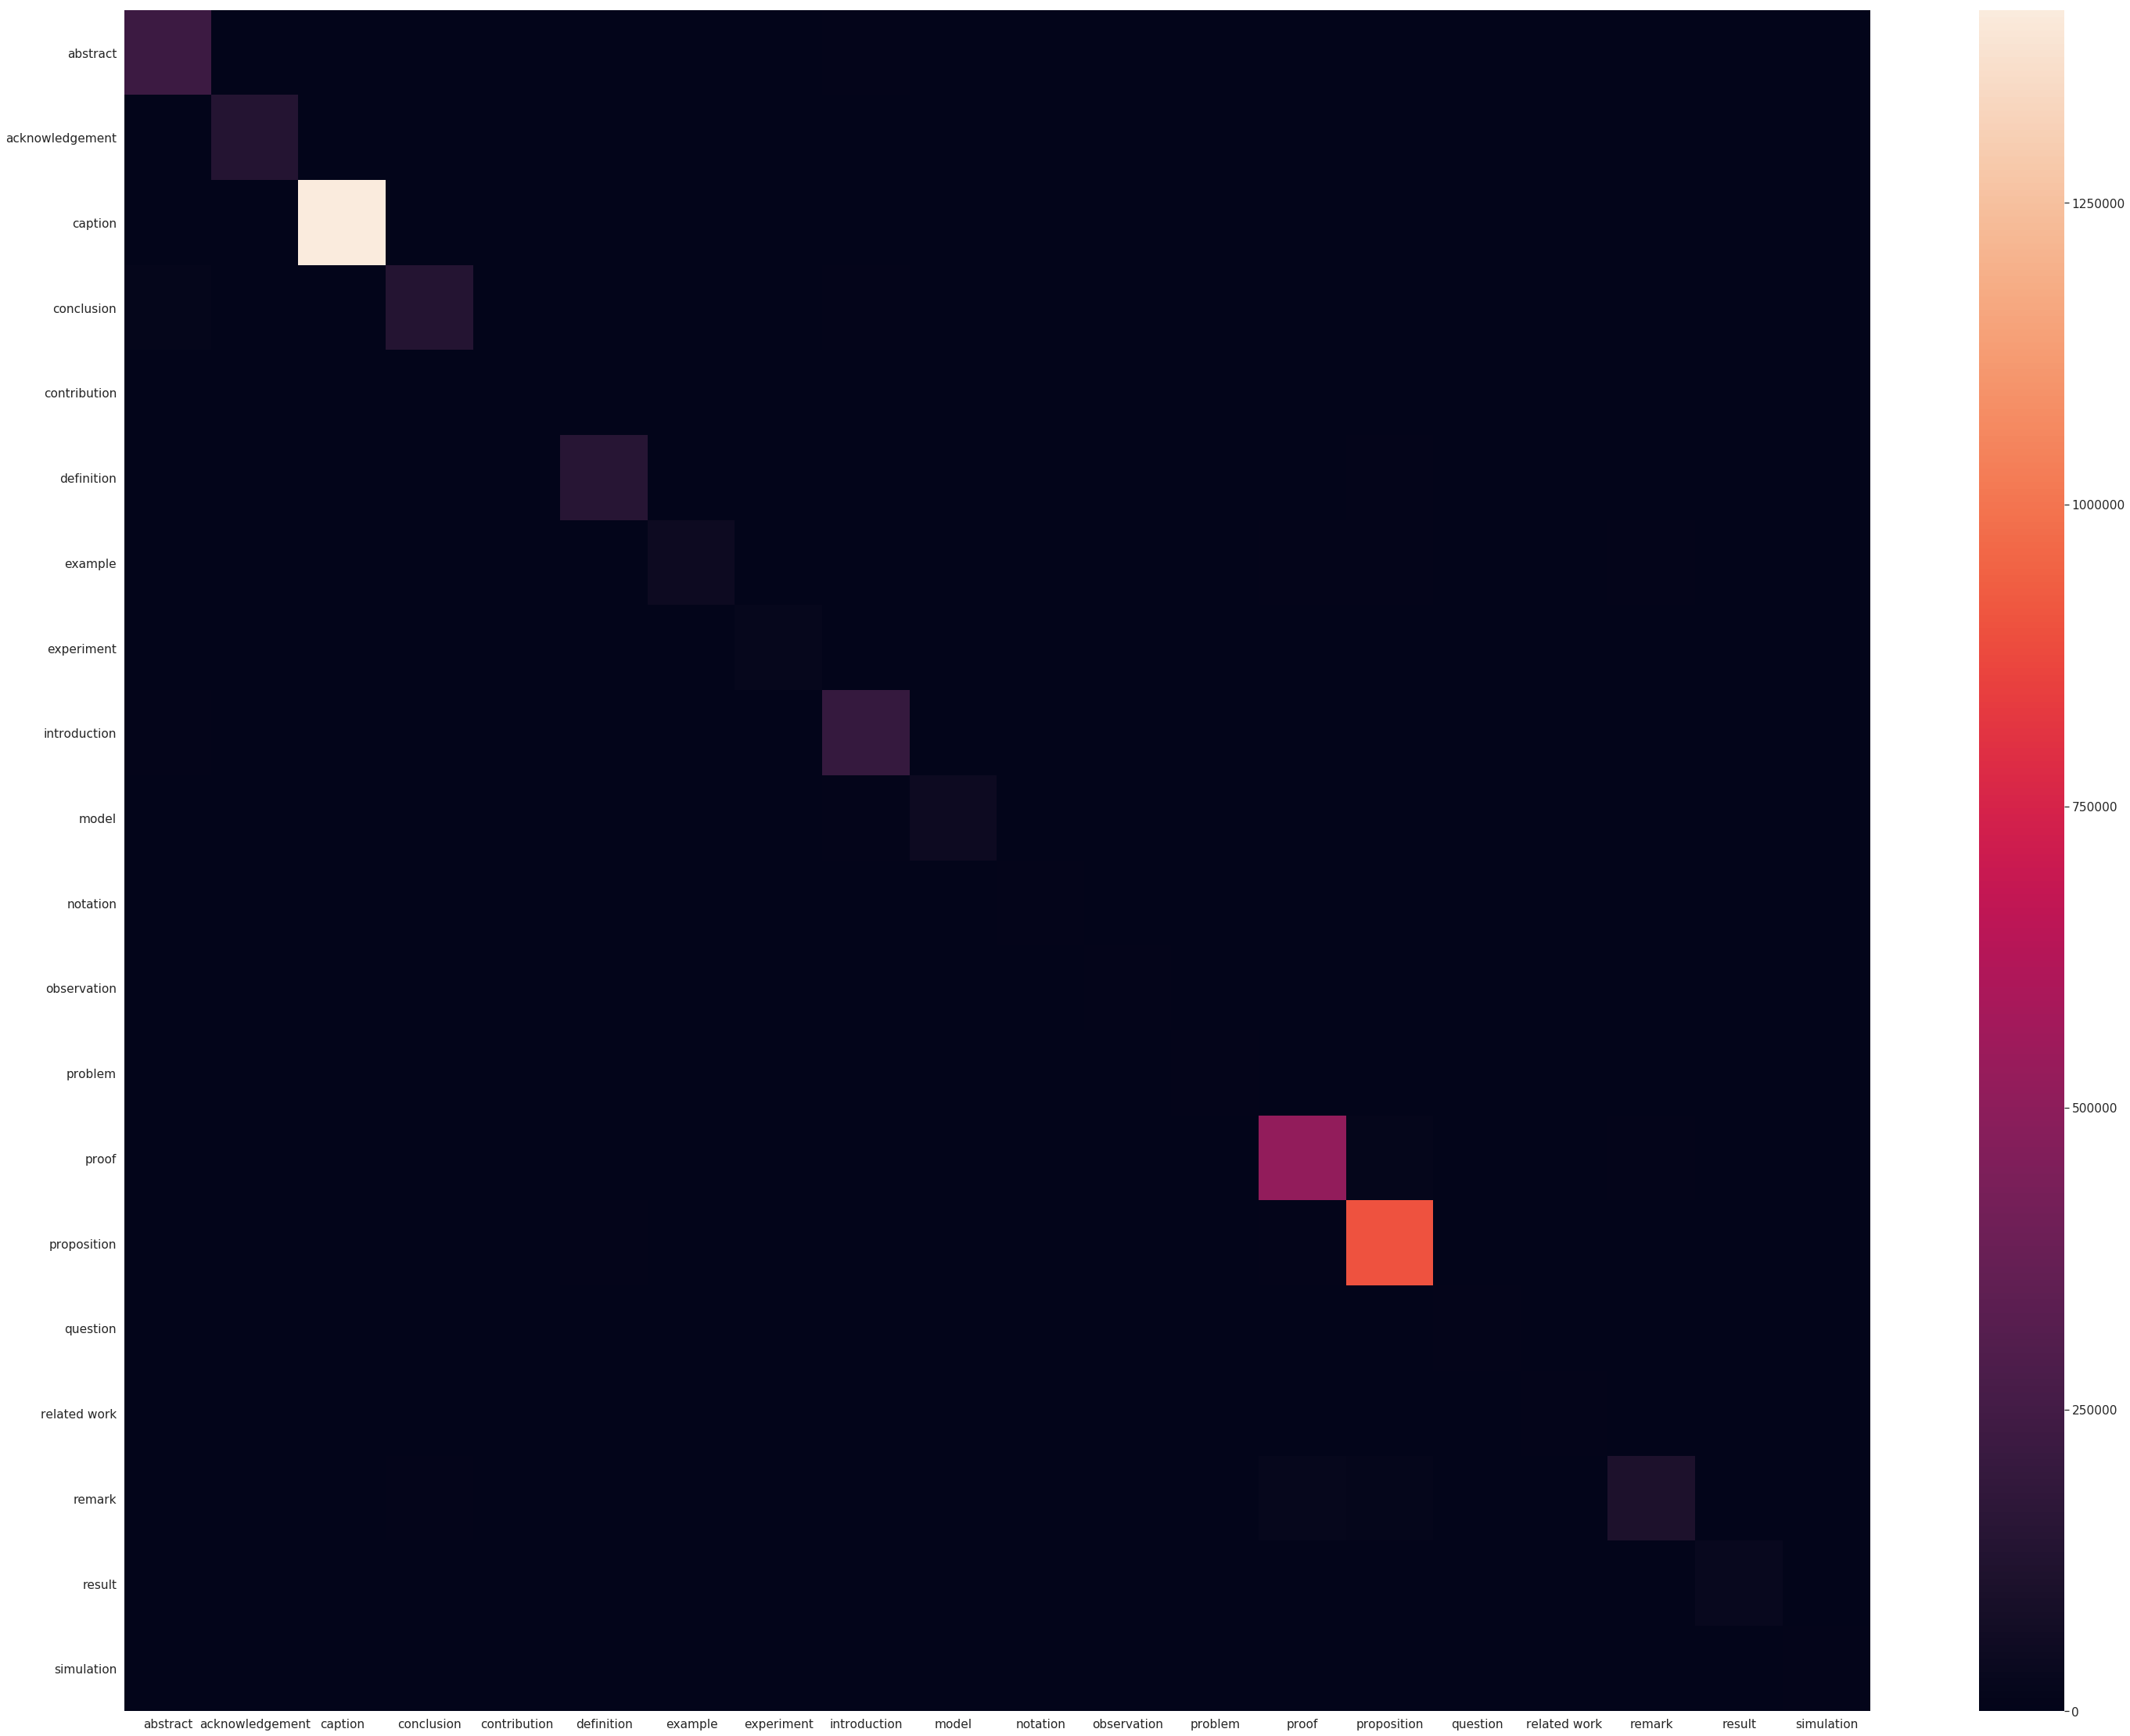

In [12]:
# Plot non-normalized confusion matrix
class_names = sorted([
    'abstract', 'acknowledgement', 'caption', 'conclusion', 'contribution', 'definition', 'example',
    'experiment', 'introduction', 'model', 'notation', 'observation', 'problem', 'proof', 'proposition',
    'question', 'related work', 'remark', 'result', 'simulation'])

plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


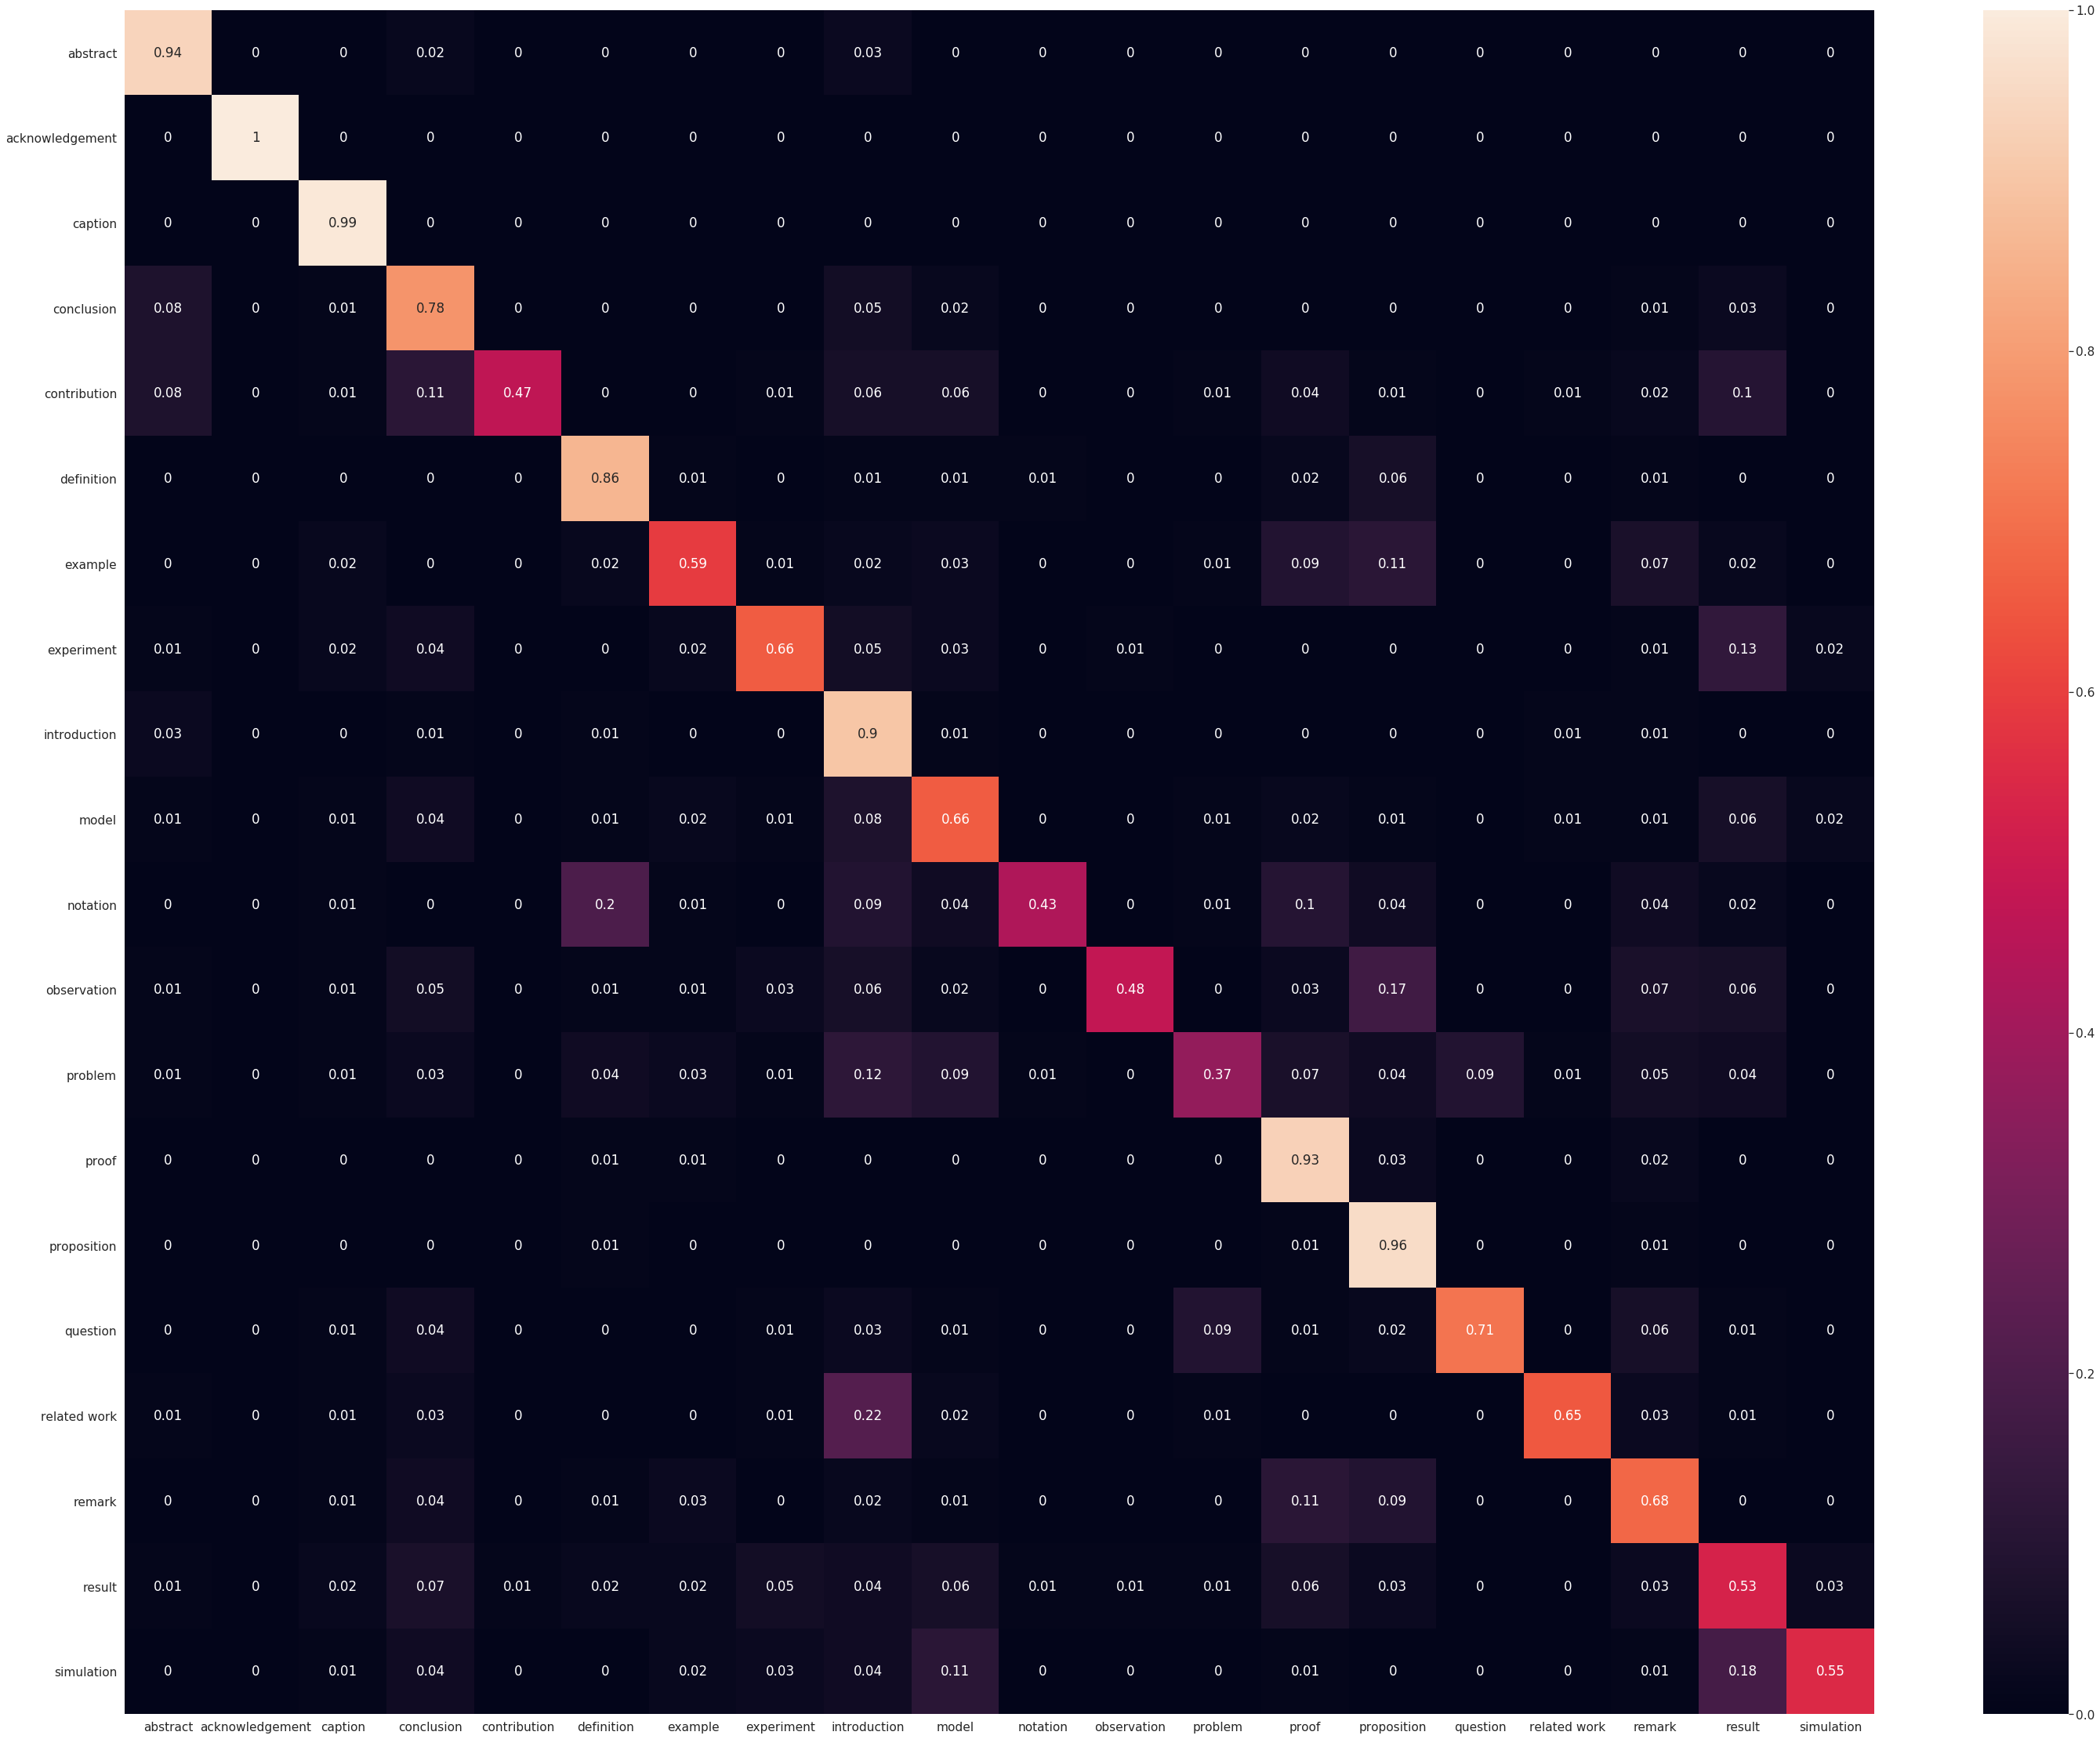

In [13]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Discussion

Converges in 7 epochs on 17.7 million paragraphs in training (10% of which used for validation, 90% for training), then tested on an unseen test set numbering 4.4 paragraphs.

## Per-class test measures:
```
'model', 'notation', 'observation', 'problem', 'proof', 'proposition',
    'question', 'related work', 'remark', 'result', 'simulation'

Per-class test measures:
4329582/4329582 [==============================] - 1976s 456us/step
                 precision    recall  f1-score   support

       abstract       0.90      0.94      0.92    233585
acknowledgement       1.00      1.00      1.00    136198
        caption       0.99      0.99      0.99   1419647
     conclusion       0.84      0.78      0.81    171145
   contribution       0.66      0.47      0.55      5841
     definition       0.85      0.86      0.85    168934
        example       0.72      0.59      0.65     78045
     experiment       0.72      0.66      0.69     28253
   introduction       0.82      0.90      0.86    221562
          model       0.68      0.66      0.67     70144
       notation       0.61      0.43      0.51     13913
    observation       0.83      0.48      0.61     16241
        problem       0.61      0.37      0.46     25397
          proof       0.91      0.93      0.92    554749
    proposition       0.94      0.96      0.95    935516
       question       0.67      0.71      0.69      7955
   related work       0.73      0.65      0.69     10982
         remark       0.77      0.68      0.72    159598
         result       0.56      0.53      0.55     59998
     simulation       0.57      0.55      0.56     11879

      micro avg       0.91      0.91      0.91   4329582
      macro avg       0.77      0.71      0.73   4329582
   weighted avg       0.91      0.91      0.91   4329582
```

In [14]:
# Let's collect some misclassification examples
# Traverses the entire test set, takes ~5-10 minutes
confusion_examples = {}
correct_examples = {}

confusion_target = 19 * 18
correct_target = 19

confusion_collected = 0
correct_collected = 0
index = 0
max_index = data_hf['y_test'].shape[0]

while index < max_index and confusion_collected < confusion_target or correct_collected < correct_target:
    pred_label = y_pred[index]
    true_label = data_hf['y_test'][index]
    
    if true_label == pred_label:
        if not (true_label in correct_examples):
            correct_examples[true_label] = data_hf['x_test'][index]
            correct_collected += 1
#             print("collected correct: %d ; wrong: %d" % (correct_collected,confusion_collected))
    else:
        if not (true_label in confusion_examples):
            confusion_examples[true_label] = {}
        if not (pred_label in confusion_examples[true_label]):
            confusion_examples[true_label][pred_label] = data_hf['x_test'][index]
            confusion_collected += 1
#             print("collected correct: %d ; wrong: %d" % (correct_collected,confusion_collected))
    index+=1

In [19]:
from IPython.display import HTML, display
import tabulate

vocab = load_index_vocab()  
vocab[989137] = "<unk>"
classification_report = [["True Label", "Predicted Label", "Content"]]
for (label, example) in sorted(correct_examples.items()):
    text = " ".join([vocab[wordidx] if wordidx != 0 else '' for wordidx in example])
    classification_report.append([class_names[label],class_names[label], text])
for (true_label, wrong_examples) in sorted(confusion_examples.items()):
    for (confused_label, wrong_example) in sorted(wrong_examples.items()):
        text = " ".join([vocab[wordidx] if wordidx != 0 else '' for wordidx in wrong_example])
        classification_report.append([class_names[true_label],class_names[confused_label], text])
        
display(HTML(tabulate.tabulate(classification_report, tablefmt='html')))


True Label,Predicted Label
abstract,abstract
acknowledgement,acknowledgement
caption,caption
conclusion,conclusion
contribution,contribution
definition,definition
example,example
experiment,experiment
introduction,introduction
model,model


In [20]:
import csv
with open('classification_examples_20class.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(classification_report)
writeFile.close()